In [1]:
import torch
from einops import rearrange
from timm.models import create_model
from optim_factory import create_optimizer

from engine_for_vqnsp import evaluate, train_one_epoch, calculate_codebook_usage
from utils import NativeScalerWithGradNormCount as NativeScaler
import modeling_vqnsp
import utils

In [49]:
model = create_model(
        'vqnsp_encoder_base_decoder_3x200x12',
        pretrained=False,
        as_tokenzer=False,
        n_code=8192,
        code_dim=64,
        EEG_size=1600,
        decay=0.99,
        quantize_kmeans_init=True
    )

{}
Final encoder config {'EEG_size': 1600, 'patch_size': 200, 'in_chans': 1, 'num_classes': 0, 'embed_dim': 200, 'depth': 12, 'num_heads': 10, 'mlp_ratio': 4.0, 'qkv_bias': True, 'qk_scale': None, 'drop_rate': 0.0, 'attn_drop_rate': 0.0, 'drop_path_rate': 0.0, 'norm_layer': functools.partial(<class 'torch.nn.modules.normalization.LayerNorm'>, eps=1e-06), 'init_values': 0.0, 'use_abs_pos_emb': True, 'use_rel_pos_bias': False, 'use_shared_rel_pos_bias': False, 'use_mean_pooling': True, 'init_scale': 0.001}
Final decoder config {'EEG_size': 8, 'patch_size': 1, 'in_chans': 64, 'num_classes': 0, 'embed_dim': 200, 'depth': 3, 'num_heads': 10, 'mlp_ratio': 4.0, 'qkv_bias': True, 'qk_scale': None, 'drop_rate': 0.0, 'attn_drop_rate': 0.0, 'drop_path_rate': 0.0, 'norm_layer': functools.partial(<class 'torch.nn.modules.normalization.LayerNorm'>, eps=1e-06), 'init_values': 0.0, 'use_abs_pos_emb': True, 'use_rel_pos_bias': False, 'use_shared_rel_pos_bias': False, 'use_mean_pooling': True, 'init_sca

In [50]:
model_state_dict = torch.load("/home/mila/r/roy.eyono/LaBraM/checkpoints/vqnsp/checkpoint-99.pth")

In [51]:
model.load_state_dict(model_state_dict["model"])

<All keys matched successfully>

In [56]:
model.to('cuda')

VQNSP(
  (encoder): NeuralTransformer(
    (patch_embed): TemporalConv(
      (conv1): Conv2d(1, 8, kernel_size=(1, 15), stride=(1, 8), padding=(0, 7))
      (gelu1): GELU(approximate='none')
      (norm1): GroupNorm(4, 8, eps=1e-05, affine=True)
      (conv2): Conv2d(8, 8, kernel_size=(1, 3), stride=(1, 1), padding=(0, 1))
      (gelu2): GELU(approximate='none')
      (norm2): GroupNorm(4, 8, eps=1e-05, affine=True)
      (conv3): Conv2d(8, 8, kernel_size=(1, 3), stride=(1, 1), padding=(0, 1))
      (norm3): GroupNorm(4, 8, eps=1e-05, affine=True)
      (gelu3): GELU(approximate='none')
    )
    (pos_drop): Dropout(p=0.0, inplace=False)
    (blocks): ModuleList(
      (0-11): 12 x Block(
        (norm1): LayerNorm((200,), eps=1e-06, elementwise_affine=True)
        (attn): Attention(
          (qkv): Linear(in_features=200, out_features=600, bias=False)
          (attn_drop): Dropout(p=0.0, inplace=False)
          (proj): Linear(in_features=200, out_features=200, bias=True)
        

In [52]:
def std_norm(x):
        mean = torch.mean(x, dim=(1, 2, 3), keepdim=True)
        std = torch.std(x, dim=(1, 2, 3), keepdim=True)
        x = (x - mean) / std
        return x

In [53]:
dataset_val_list, val_ch_names_list = utils.build_pretraining_dataset([["/network/scratch/r/roy.eyono/eeg_processed/alexeeg.hdf5"]], [4])

In [54]:
sampler_val = torch.utils.data.SequentialSampler(dataset_val_list[0])
data_loader_val = torch.utils.data.DataLoader(
    dataset_val_list[0], sampler=sampler_val,
    batch_size=int(1.5 * 128),
    num_workers=10,
    pin_memory=True,
    drop_last=False
)

In [79]:
input_chans = utils.get_input_chans(val_ch_names_list[0])
for eeg in data_loader_val:
        print(eeg.shape)
        x = eeg.float().cuda()
        x = rearrange(x, 'B N (A T) -> B N A T', T=200)
        print(x.shape)
        x_fft = torch.fft.fft(x, dim=-1)
        amplitude = torch.abs(x_fft)
        amplitude = std_norm(amplitude)
        angle = torch.angle(x_fft)
        angle = std_norm(angle)
        quantize, embed_ind, emb_loss = model.encode(x, input_chans)
        xrec, xrec_angle = model.decode(quantize, input_chans)
        break

print(xrec.shape)



/home/mila/r/roy.eyono/.conda/envs/labram/lib/python3.11/site-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 10 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


torch.Size([192, 16, 800])
torch.Size([192, 16, 4, 200])
torch.Size([192, 64, 200])


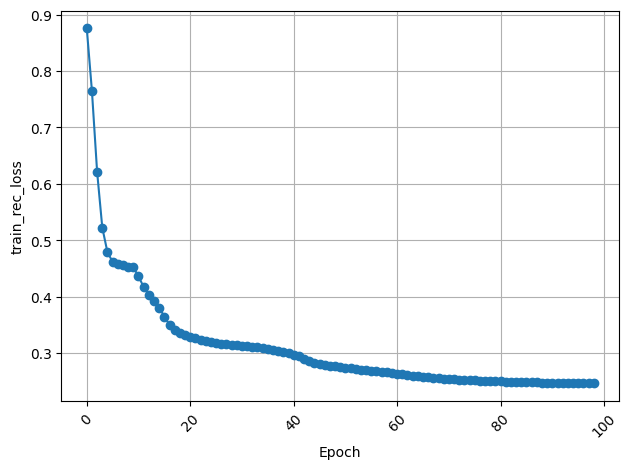

In [82]:
import json
import matplotlib.pyplot as plt
from datetime import datetime

# Initialize lists to store time points and values
timestamps = []
values = []

# Open and read the log file
with open('/home/mila/r/roy.eyono/LaBraM/checkpoints/vqnsp/log.txt', 'r') as f:
    for line in f:
        # Parse each line as a JSON object (dictionary)
        data = json.loads(line)
        
        # Extract the timestamp and the field of interest
        value = data['train_rec_loss']  # Replace 'value' with your desired field name
        
        values.append(value)

# Plot the field over time
plt.plot(values, marker='o')
plt.xlabel('Epoch')
plt.ylabel('train_rec_loss')  # Replace 'Value' with your field's name
plt.grid(True)
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.tight_layout()  # Adjust layout to prevent clipping of labels
plt.show()